In [1]:
import numpy as np
import matplotlib.pyplot as plt
from linear_model_for_regression import \
    (Polynomial,
     RBF,
     Sigmoid,
     LinearRegression,
     RidgeRegression,
     BayesianLinearRegression,
     VariationalLinearRegression
     )

In [2]:
def create_data(func, x, size, param):
    y = func(2*np.pi*x) + np.random.normal(param[0], param[1], size)
    return y

## 2.1 Linear model for regression

### 2.1.1 basis function

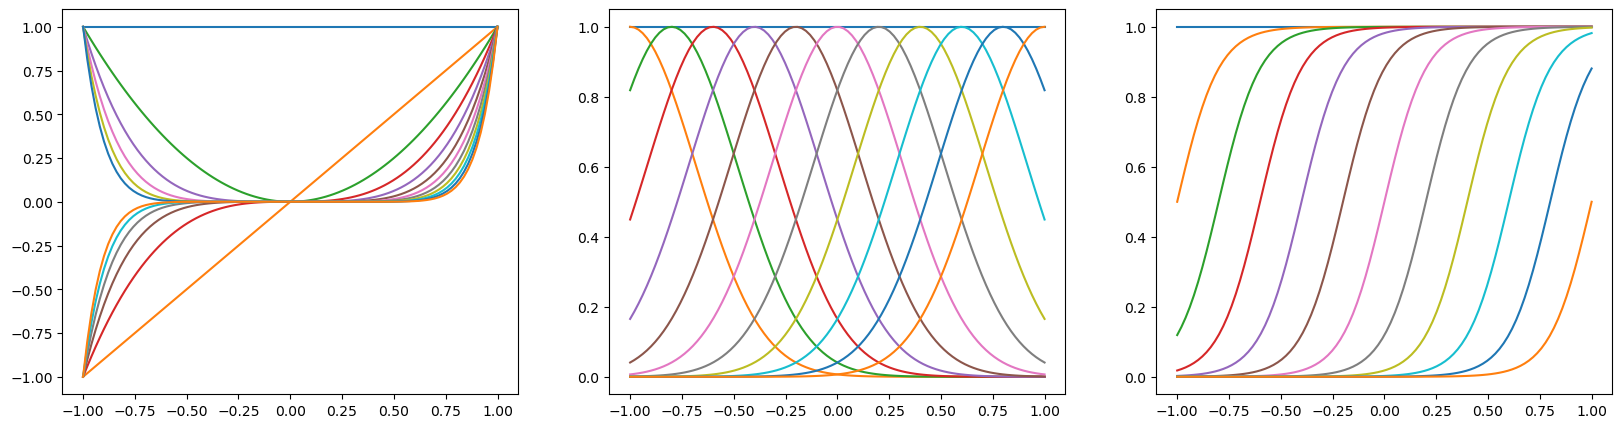

In [3]:
x = np.linspace(-1, 1, 100).reshape(-1, 1)
polynomial = Polynomial(11)
rbf = RBF(np.linspace(-1, 1, 11), 0.1)
sigmoid = Sigmoid(np.linspace(-1, 1, 11), 0.1)
fig = plt.figure(figsize=(20, 5))
for i, y in enumerate([polynomial(x), rbf(x), sigmoid(x)]):
    plt.subplot(1, 3, i+1)
    for j in range(12):
        plt.plot(x, y[:, j])
plt.show()

### 2.1.2 Least square and maximum Likelihood

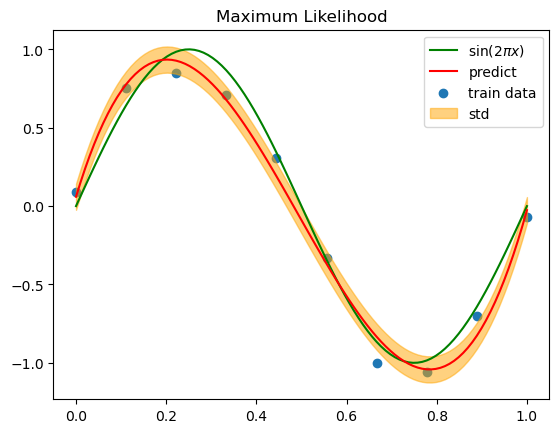

In [4]:
x_train = np.linspace(0, 1, 10)
y_train = create_data(np.sin, x_train, 10, (0, 0.1))
p = Polynomial(3)
X_train = p(x_train)
x_test = np.linspace(0, 1, 100)
X_test = p(x_test)
y_test = np.sin(2 * np.pi * x_test)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_predict, std = lr.predict(X_test, return_std=True)
plt.title("Maximum Likelihood")
plt.plot(x_test, y_test, c='green', label='$\sin(2\pi x)$')
plt.scatter(x_train, y_train, label='train data')
plt.plot(x_test, y_predict, c='red', label='predict')
y_predict = y_predict.flatten()
std = std.flatten()
plt.fill_between(x_test, y_predict-std, y_predict+std, color='orange', alpha=0.5, label='std')
plt.legend()
plt.show()

### 2.1.3 Regularization

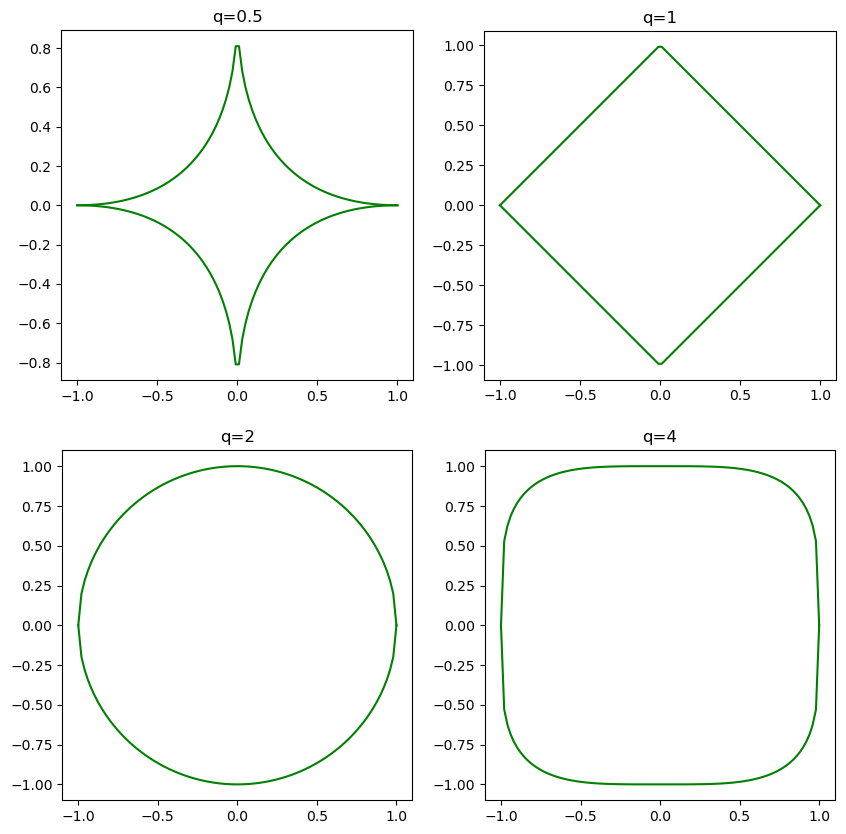

In [5]:
x = np.linspace(-1, 1, 100)
# y = np.concatenate([(1 - x ** 0.5) ** 2, (1 - x ** 0.5) ** 2])
y = (1 - abs(x) ** 0.5) ** 2
plt.figure(figsize=(10, 10))
plt.gca().set_aspect('equal')
plt.subplot(2, 2, 1)
plt.title("q=0.5")
plt.plot(x, y, c='green')
plt.plot(x, -y, c='green')

plt.subplot(2, 2, 2)
plt.title("q=1")
y = 1 - abs(x)
plt.plot(x, y, c='green')
plt.plot(x, -y, c='green')
plt.gca().set_aspect('equal')

plt.subplot(2, 2, 3)
plt.title("q=2")
y = (1 - x ** 2) ** 0.5
plt.plot(x, y, c='green')
plt.plot(x, -y, c='green')
plt.gca().set_aspect('equal')

plt.subplot(2, 2, 4)
plt.title("q=4")
y = (1 - x ** 4) ** 0.25
plt.plot(x, y, c='green')
plt.plot(x, -y, c='green')
plt.gca().set_aspect('equal')

plt.show()

### 2.1.4 Bias-Variance decomposition

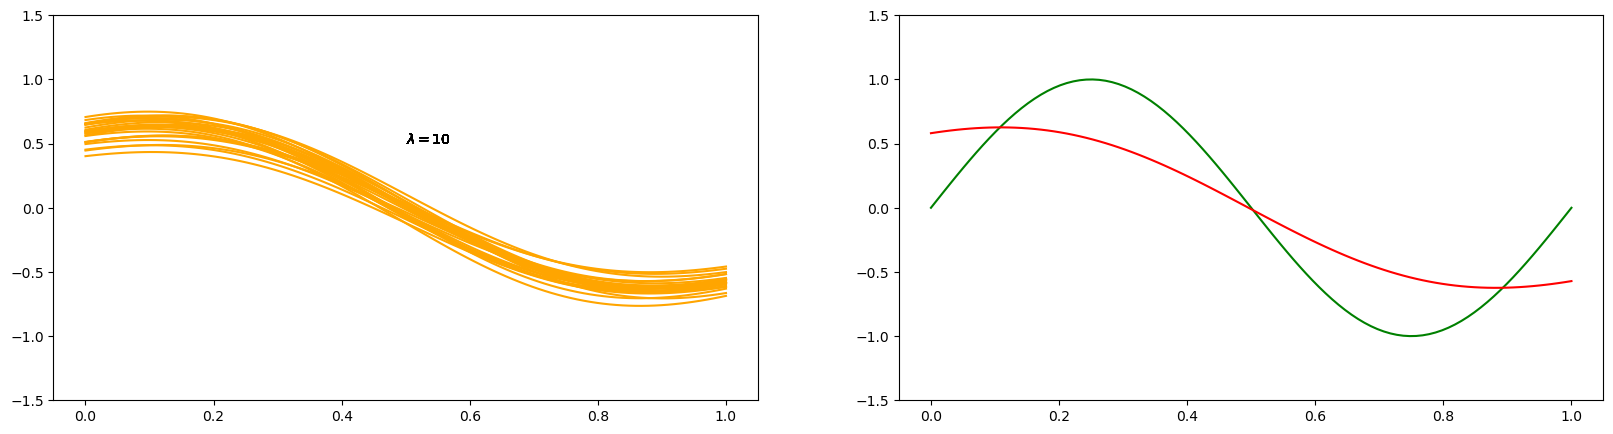

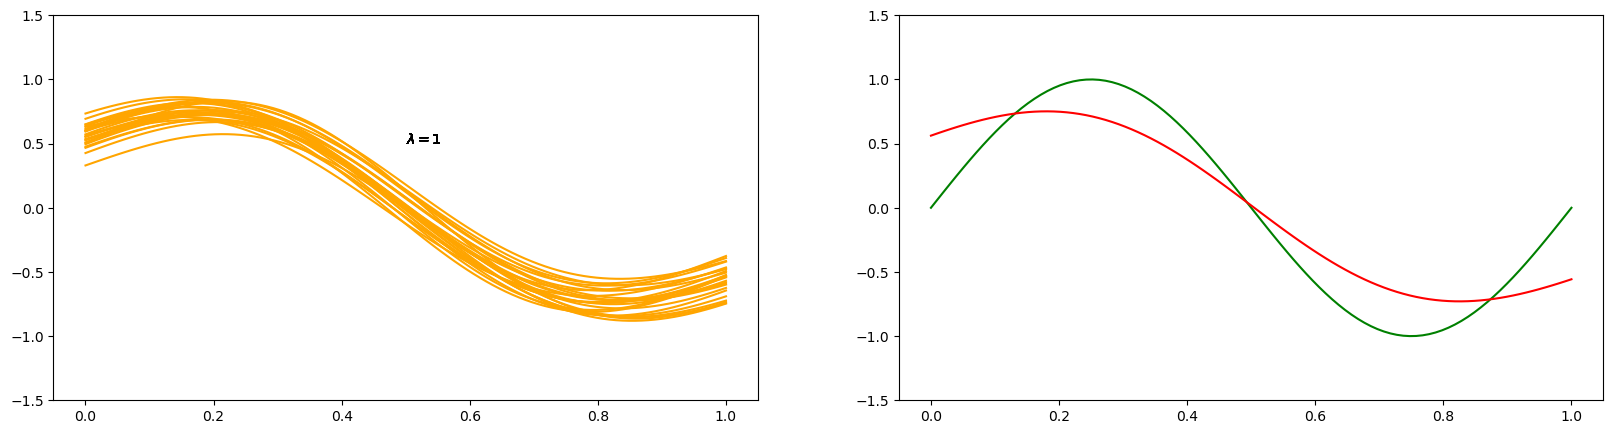

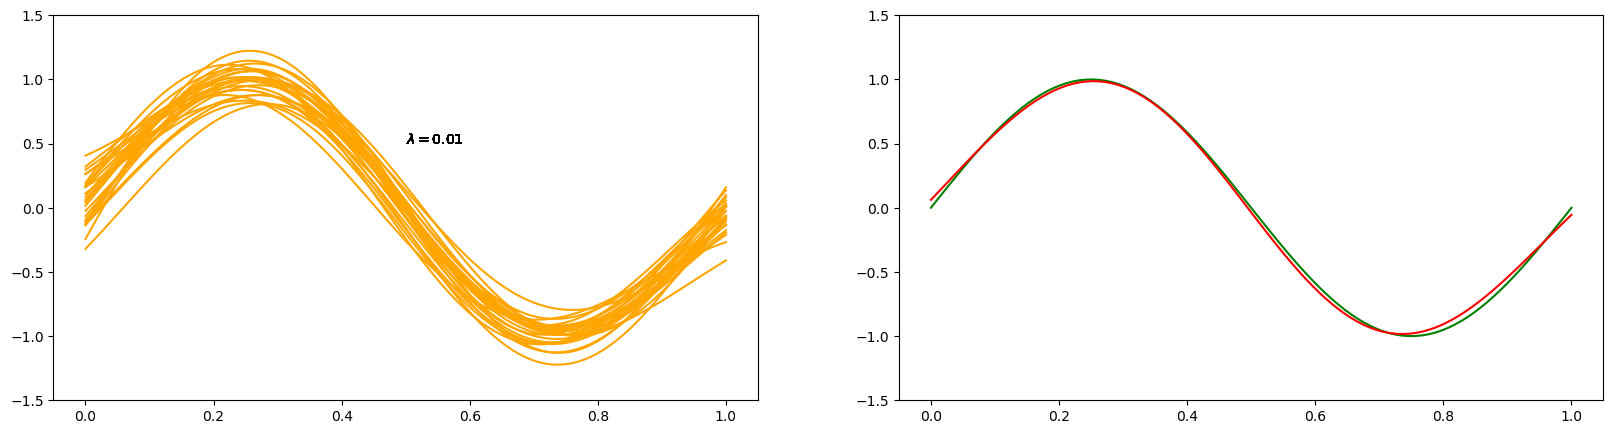

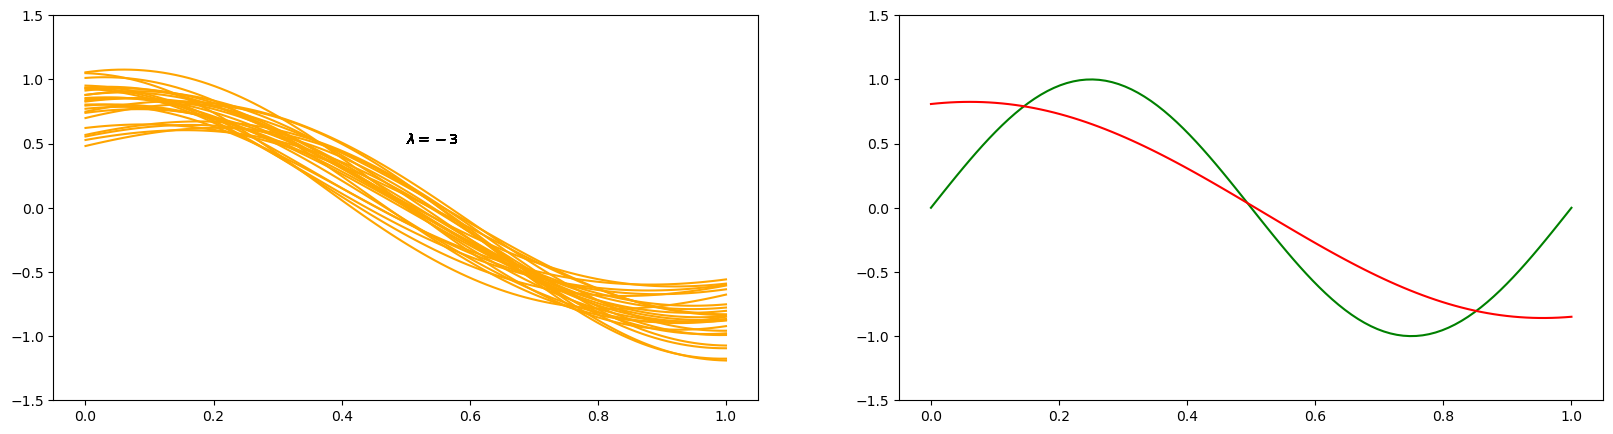

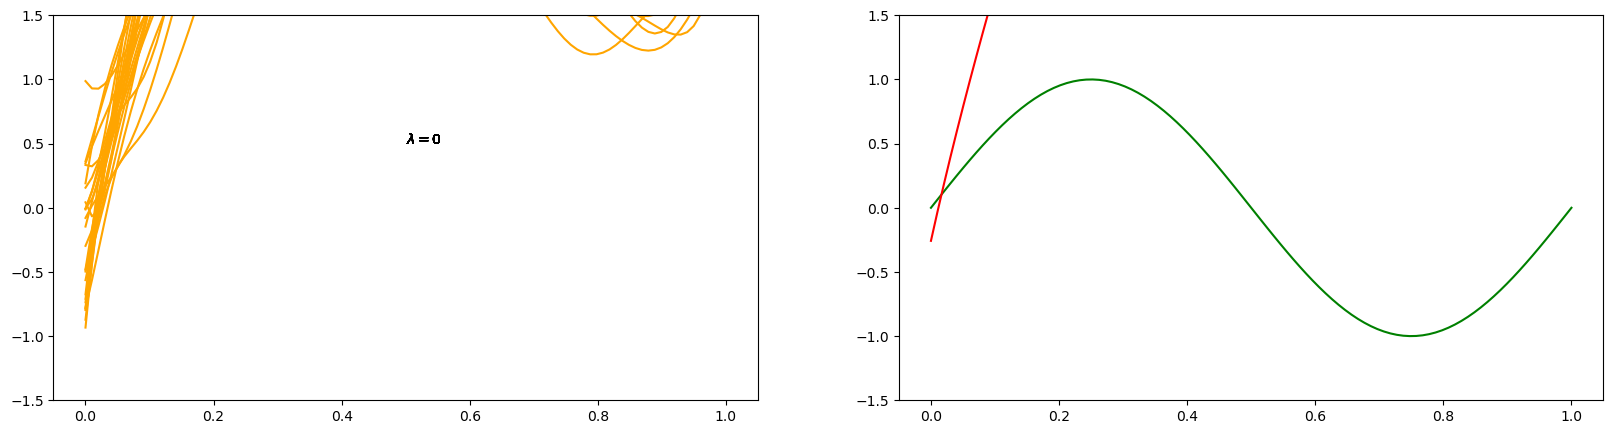

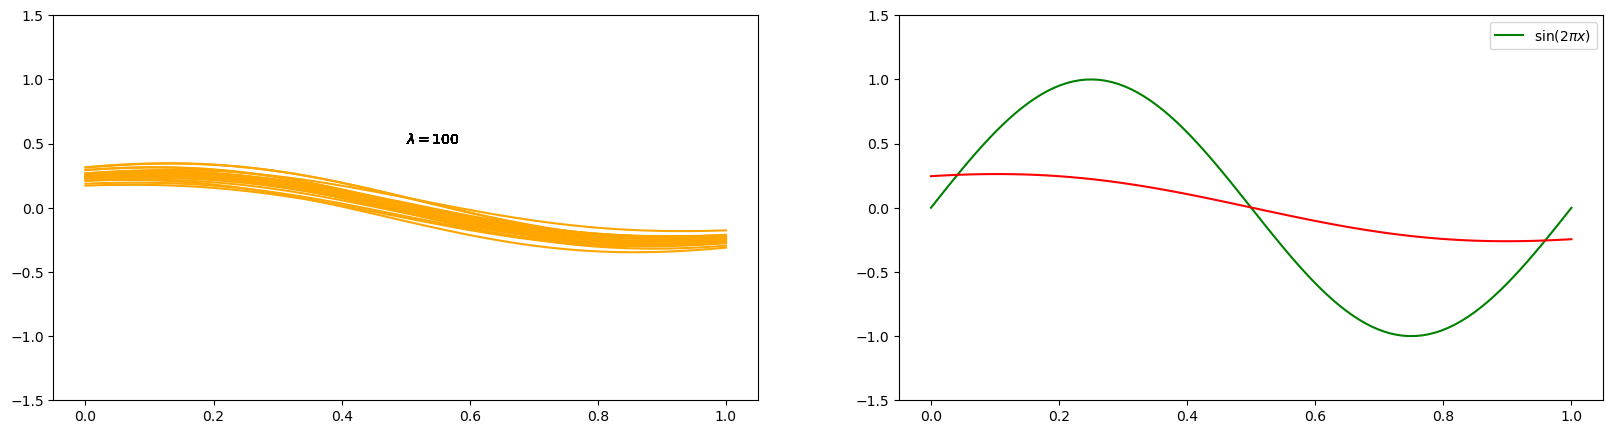

In [6]:
rbf = RBF(np.linspace(0, 1, 25), 0.1)
x_train = np.linspace(0, 1, 25)
X_test = rbf(x_test)
X_train = rbf(x_train)
for alpha in [10, 1, 1e-2, -3, 0, 100]:
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    y = []
    for i in range(25):
        y_train = create_data(np.sin, x_train, 25, (0, 0.25))
        rr = RidgeRegression(alpha=alpha)
        rr.fit(X_train, y_train)
        y_predict = rr.predict(X_test)
        y.append(y_predict.flatten())
        plt.plot(x_test, y_predict, c='orange')
        plt.annotate(f'$\lambda ={alpha}$', (0.5, 0.5))
    plt.ylim(-1.5, 1.5)
    plt.subplot(1, 2, 2)
    plt.plot(x_test, y_test, c='green', label='$\sin(2\pi x)$')
    plt.plot(x_test, np.asarray(y).mean(axis=0), c='red')
    plt.ylim(-1.5, 1.5)
plt.legend()
plt.show()

### 2.2 Bayes Linear Regression

### 2.2.1 Parameter distribution

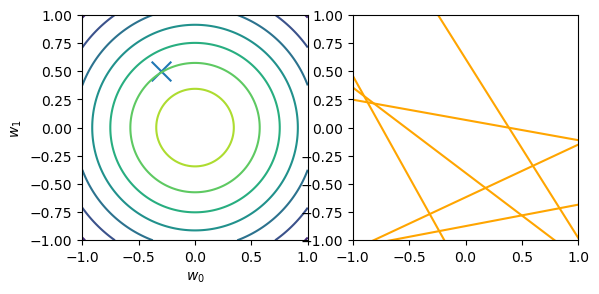

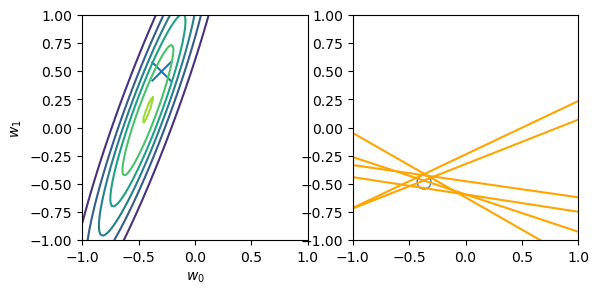

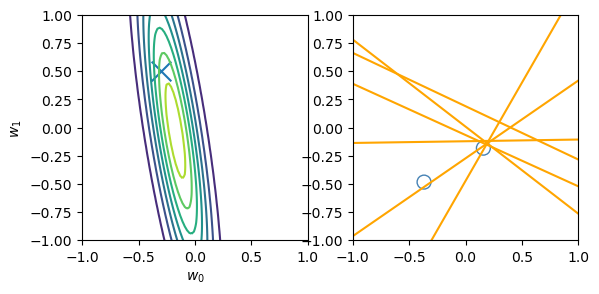

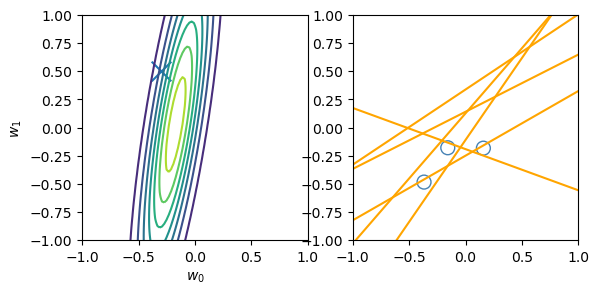

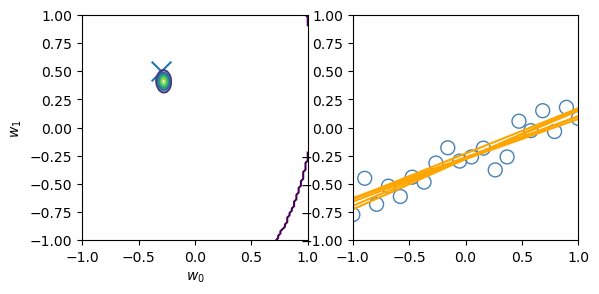

In [7]:
from scipy.stats import multivariate_normal
def linear_data(x, size, param):
    y = -0.3 + 0.5 * x
    return y + np.random.normal(param[0], param[1], size)

x_test = np.linspace(-1, 1, 100)
x_train = np.linspace(-1, 1, 20)
np.random.shuffle(x_train)
y_train = linear_data(x_train, 20, (0, 0.1))
w0, w1 = np.meshgrid(np.linspace(-1, 1 ,100), np.linspace(-1, 1, 100))
w = np.array([w0, w1]).transpose(1, 2, 0)
p = Polynomial(degree=1)
X_train = p(x_train)
X_test = p(x_test)
model = BayesianLinearRegression(1.0, 50)
for begin, end in [[0, 0], [0, 1], [1, 2], [2, 3], [3, 20]]:
    model.fit(X_train[begin: end], y_train[begin: end])
    plt.subplot(1, 2, 1)
    plt.scatter(-0.3, 0.5, marker='x', s=200)
    plt.contour(w0, w1, multivariate_normal.pdf(w, model.w_mean, model.w_var))
    plt.gca().set_aspect('equal')
    plt.xlabel("$w_0$")
    plt.ylabel("$w_1$")

    plt.subplot(1, 2, 2)
    plt.scatter(x_train[: end], y_train[:end], s=100, facecolor='none' ,edgecolors='steelblue', lw=1)
    plt.plot(x_test, model.sample(X_test, size=6), c='orange')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()



### 2.2.2 Predictive distribution

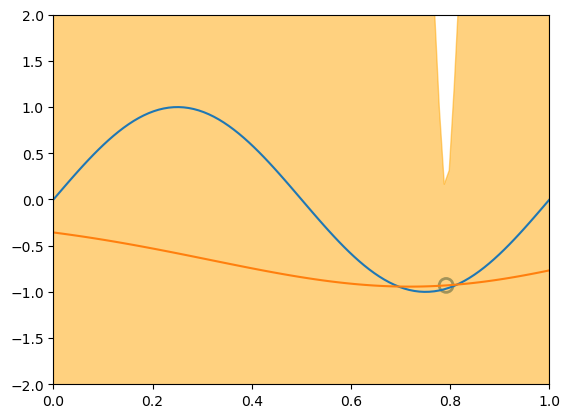

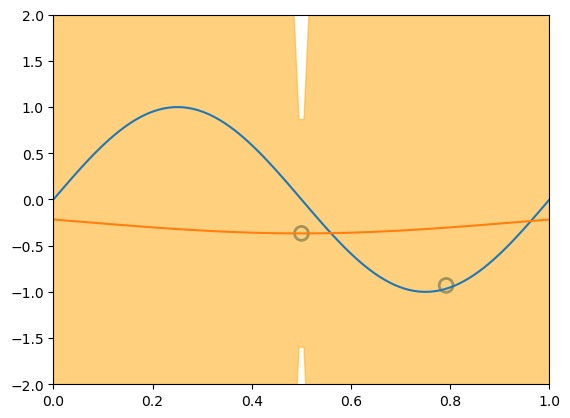

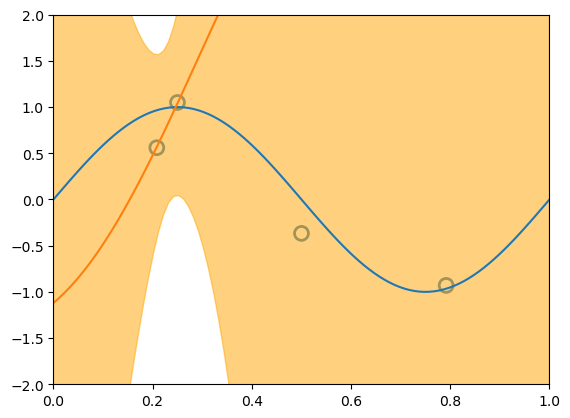

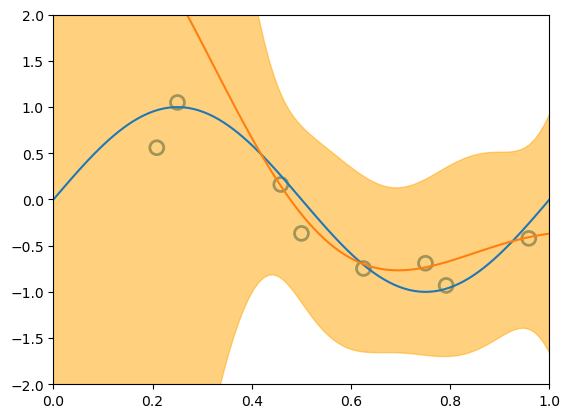

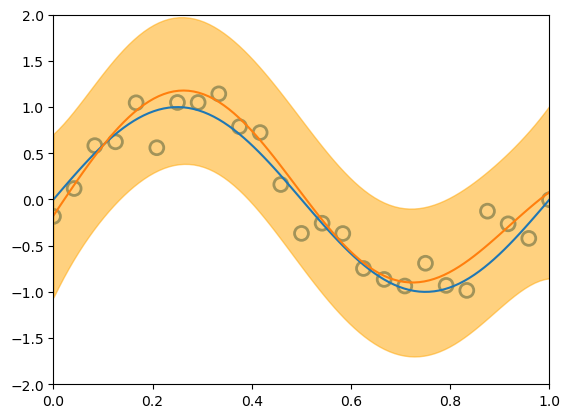

In [8]:
x_train = np.linspace(0, 1 ,25)
np.random.shuffle(x_train)
y_train = create_data(np.sin, x_train, 25, (0, 0.25))
x_test = np.linspace(0, 1, 100)
y_test = np.sin(2 * np.pi * x_test)
rbf = RBF(np.linspace(0, 1, 9), 0.1)
X_train = rbf(x_train)
X_test = rbf(x_test)
model = BayesianLinearRegression(alpha=1e-3, beta=2.0)
for begin, end in [[0, 1], [1, 2], [2, 4], [4, 8], [8, 25]]:
     model.fit(X_train[begin: end], y_train[begin: end])
     y, y_std = model.predict(X_test, return_std=True)
     plt.scatter(x_train[:end], y_train[:end], s=100, facecolor="none", edgecolor="steelblue", lw=2)
     plt.plot(x_test, y_test)
     plt.plot(x_test, y)
     plt.fill_between(x_test, y - y_std, y + y_std, color="orange", alpha=0.5)
     plt.xlim(0, 1)
     plt.ylim(-2, 2)
     plt.show()

### *Variational Linear Regression

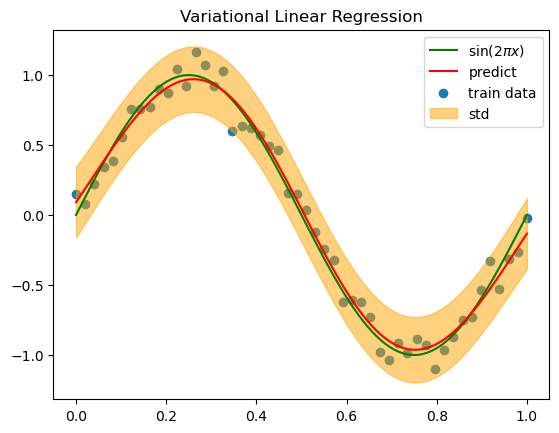

In [13]:
x_train = np.linspace(0, 1, 50)
y_train = create_data(np.sin, x_train, 50, (0, 0.1))
p = rbf
X_train = p(x_train)
x_test = np.linspace(0, 1, 100)
X_test = p(x_test)
y_test = np.sin(2 * np.pi * x_test)
vlr = VariationalLinearRegression()
vlr.fit(X_train, y_train, 50)
y_predict, std = vlr.predict(X_test, return_std=True)
plt.title("Variational Linear Regression")
plt.plot(x_test, y_test, c='green', label='$\sin(2\pi x)$')
plt.scatter(x_train, y_train, label='train data')
plt.plot(x_test, y_predict, c='red', label='predict')
y_predict = y_predict.flatten()
std = std.flatten()
plt.fill_between(x_test, y_predict-std, y_predict+std, color='orange', alpha=0.5, label='std')
plt.legend()
plt.show()